In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR 
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Split Training & Testing Data


*   Training data: 2010 - 2018
*   Testing data: 2019 - 2021



|     Model     | factor | Window size | Step size | Horizon |
| :-----------: | :----: | :---------: | :-------: | :-----: |
|  1 day ahead  | close (1c)  |      3      |     1     |    1    |
|               |  all (1a)   |      3      |     1     |    1    |
| 5 days ahead  | close (5c)  |      8      |     1     |    5    |
|               |  all (5a)   |      8      |     1     |    5    |
| 22 days ahead | close (22c)  |     25      |     1     |   22    |
|               |  all (22a)   |     25      |     1     |   22    |

In [ ]:
# Read data & split by year
def split_train_test(file_path, start_year, mid_year, final_year):
  full_dataset = pd.read_excel(file_path)
  training_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(start_year, mid_year))]
  testing_ori = full_dataset[full_dataset['Date - 0'].dt.year.isin(np.arange(mid_year, final_year))]
  return training_ori, testing_ori

Data Select
1.   ONE day ahead


*   close (1c)
*   all factors (1a)



In [ ]:
training_ori, testing_ori = split_train_test('/content/drive/MyDrive/EC503/Coding/Regression/SVR/amazon_3_1.xlsx',
                        2010, 2019, 2022)

# WindowSize = 3, Horizon = 1, factor = all
X_train_1a = training_ori.loc[:, 'Open - 2':'Close - 0']
X_test_1a = testing_ori.loc[:, 'Open - 2':'Close - 0']

# WindowSize = 3, Horizon = 1, factor = close
X_train_1c = X_train_1a.loc[:, 'Close - 2':'Close - 0']
X_test_1c = X_test_1a.loc[:, 'Close - 2':'Close - 0']

Y_train_1 = training_ori.iloc[:, -1]
Y_test_1 = testing_ori.iloc[:, -1]

2.   FIVE days ahead


*   close (5c)
*   all factors (5a)



In [ ]:
training_ori, testing_ori = split_train_test('/content/drive/MyDrive/EC503/Coding/Regression/SVR/amazon_8_5.xlsx',
                        2010, 2019, 2022)

# WindowSize = 8, Horizon = 5, factor = all
X_train_5a = training_ori.loc[:, 'Open - 7':'Close - 0']
X_test_5a = testing_ori.loc[:, 'Open - 7':'Close - 0']

# WindowSize = 8, Horizon = 5, factor = close
X_train_5c = X_train_5a.loc[:, 'Close - 7':'Close - 0']
X_test_5c = X_test_5a.loc[:, 'Close - 7':'Close - 0']

Y_train_5 = training_ori.iloc[:, -1]
Y_test_5 = testing_ori.iloc[:, -1]

3.   TWENTY-TWO days ahead

*   close (22c)
*   all factors (22a)


In [ ]:
training_ori, testing_ori = split_train_test('/content/drive/MyDrive/EC503/Coding/Regression/SVR/amazon_25_22.xlsx',
                        2010, 2019, 2022)

# WindowSize = 25, Horizon = 22, factor = all
X_train_22a = training_ori.loc[:, 'Open - 24':'Close - 0']
X_test_22a = testing_ori.loc[:, 'Open - 24':'Close - 0']

# WindowSize = 25, Horizon = 22, factor = close
X_train_22c = X_train_22a.loc[:, 'Close - 24':'Close - 0']
X_test_22c = X_test_22a.loc[:, 'Close - 24':'Close - 0']

Y_train_22 = training_ori.iloc[:, -1]
Y_test_22 = testing_ori.iloc[:, -1]

In [ ]:
X_train = [X_train_1a, X_train_1c, X_train_5a, X_train_5c, X_train_22a, X_train_22c]
X_test = [X_test_1a, X_test_1c, X_test_5a, X_test_5c, X_test_22a, X_test_22c]
Y_train = [Y_train_1, Y_train_5, Y_train_22]
Y_test = [Y_test_1, Y_test_5, Y_test_22]

(707,)

### Tune gamma and C by GridSearchCV

In [ ]:
parameters = {
    'kernel' : ['rbf'],
    'C': [1e2, 1e3, 1e4, 1e5],
    'gamma': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}
best_param = []
MAPE = []
Y_pred = []
grid_svr = GridSearchCV(SVR(), parameters, cv = 5, verbose = 2)

for i in range(6):
  grid_svr.fit(X_train[i], Y_train[i//2])
  Y = grid_svr.predict(X_test[i])
  Y_pred.append(Y)
  best_param.append(grid_svr.best_estimator_)
  MAPE.append(mean_absolute_percentage_error(Y_test[i//2], Y))

In [ ]:
MAPE

[0.01655475451630191,
 0.009962393575047678,
 0.06158228326504158,
 0.03487723979502312,
 0.06327577172094169,
 0.12599536648543935]

### Plot Part

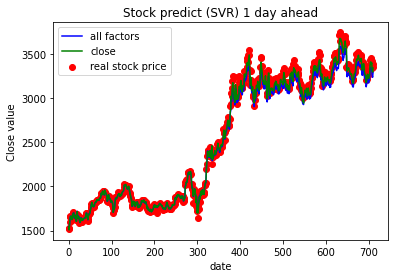

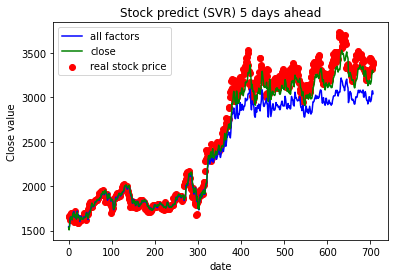

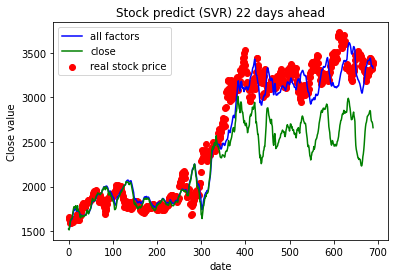

In [ ]:
titles = ['1 day ahead', '5 days ahead', '22 days ahead']
for i in range(3):
  size = Y_test[i].shape[0]
  plt.scatter(range(size), Y_test[i], color = 'red', label='real stock price')
  plt.plot(range(size), Y_pred[2*i], color = 'blue', label='all factors')
  plt.plot(range(size), Y_pred[2*i+1], color = 'green', label='close')
  plt.title('Stock predict (SVR) ' + titles[i])
  plt.xlabel('date')
  plt.ylabel('Close value')
  plt.legend()
  plt.show()

Kernel Ridge Regression

In [ ]:
parameters_krr = {
    'kernel' : ['rbf'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'gamma': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

best_param_krr = []
MAPE_krr = []
Y_pred_krr = []

grid_krr = GridSearchCV(KernelRidge(), parameters_krr, cv = 5, verbose = 2)

for i in range(6):
  grid_krr.fit(X_train[i], Y_train[i//2])
  Y = grid_krr.predict(X_test[i])
  Y_pred_krr.append(Y)
  best_param_krr.append(grid_krr.best_estimator_)
  MAPE_krr.append(mean_absolute_percentage_error(Y_test[i//2], Y))

In [ ]:
best_param_krr

[KernelRidge(alpha=0.0001, gamma=1e-09, kernel='rbf'),
 KernelRidge(alpha=0.0001, gamma=1e-09, kernel='rbf'),
 KernelRidge(alpha=0.0001, gamma=1e-10, kernel='rbf'),
 KernelRidge(alpha=0.0001, gamma=1e-09, kernel='rbf'),
 KernelRidge(alpha=0.0001, gamma=1e-10, kernel='rbf'),
 KernelRidge(alpha=0.001, gamma=1e-09, kernel='rbf')]

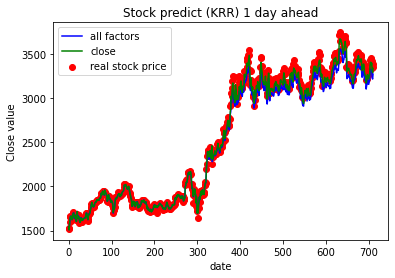

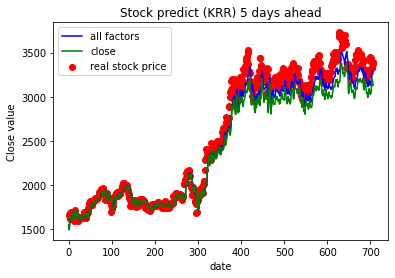

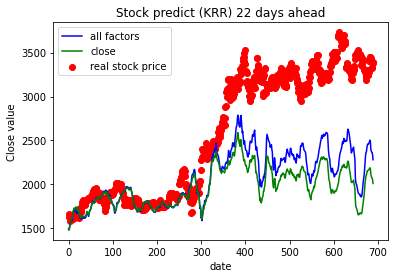

In [ ]:
titles = ['1 day ahead', '5 days ahead', '22 days ahead']
for i in range(3):
  size = Y_test[i].shape[0]
  plt.scatter(range(size), Y_test[i], color = 'red', label='real stock price')
  plt.plot(range(size), Y_pred_krr[2*i], color = 'blue', label='all factors')
  plt.plot(range(size), Y_pred_krr[2*i+1], color = 'green', label='close')
  plt.title('Stock predict (KRR) ' + titles[i])
  plt.xlabel('date')
  plt.ylabel('Close value')
  plt.legend()
  plt.show()